# Подключение библиотек

In [52]:
# Python 3.8
import pandas as pd
import numpy  as np
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.graph_objects as go

In [53]:
import tensorflow as tf
from   tensorflow.keras import layers, activations, losses, optimizers, metrics # импорт для более короткой записи

In [54]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(False)
#tf.config.set_soft_device_placement(False)

Num GPUs Available:  0


In [55]:
# Проверка версий библиотек
for lib in [pd, np, sklearn, tf]:
    print(f"{lib.__name__:<12} {lib.__version__}")

# Проверка версии и пути к выбранному интерпретатору
import sys
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

pandas       2.1.1
numpy        1.24.3
sklearn      1.3.1
tensorflow   2.12.1
Версия Python - 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Путь к интерпретатору Python - C:\Programs\Python39x64\python.exe


In [56]:
import PIL
from PIL import ImageTk, Image, ImageDraw, ImageOps

import tkinter as tk
import datetime
import os

- - - - -

# 1. Исследование MLP путём опроса отдельных слоёв

## 1.1. Создание структуры и выбор начальных параметров

In [57]:
with tf.device('/CPU:0'):
    ###########################################
    #▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
    # 1) Параметры структуры -------------------------------------------------------------------------
    input_size        = 1  # кол-во входных  узлов
    hiddenLayer_size  = 3  # кол-во узлов на скрытом слое
    output_size       = 1  # кол-во выходных узлов

    # 2.1) Построение модели нейронной сети многослойного(Sequential) типа ----------------------------
    model = tf.keras.models.Sequential()

    # ДОБАВЛЕНИЕ НОВЫХ СЛОЁВ --------------------------
    # Входной слой
    model.add(  layers.Input(
                    shape=(input_size,)
    ))

    #0.Linear - скрытый полносвязный слой с нейронами
    model.add(  layers.Dense(
                    units=hiddenLayer_size,  # параметр "units" - кол-во узлов/нейронов на данном слое
                    activation=None          # параметр "activation" - вид функции активации
        ))

    #1.ReLU - скрытый слой нелинейной функцией активации
    model.add(  layers.Activation(
                    activation=activations.relu # параметр "activation" - вид функции активации
        ))

    #2.Linear - следующий полносвязный слой с нейронами
    # Кол-во нейронов на последнем слое опредеяет кол-во выходных значений нейронной сети
    model.add( layers.Dense(
                    units=output_size,           # параметр "units" - кол-во узлов/нейронов на данном слое
                    activation=None              # параметр "activation" - вид функции активации
    ))

In [58]:
with tf.device('/CPU:0'):
    # 2.2) Функции потерь и функции оптимизации --------------------------------------------------------------------
    fLoss      = losses.CategoricalCrossentropy()
    #fLoss      = losses.BinaryCrossentropy()
    #floss      = losses.SparseCategoricalCrossentropy()

    fOptimizer = optimizers.Adam(learning_rate=0.01)
    #fOptimizer = optimizers.SGD(learning_rate=0.01)
    #fOptimizer = optimizers.RMSprop(learning_rate=0.01)

    fMetric  = [
                  metrics.CategoricalAccuracy(),
                  metrics.CategoricalCrossentropy(),
                  metrics.Precision(),
    ]

In [59]:
with tf.device('/CPU:0'):
    totalHistoryLossTrain=list() # Вспомогательный список для хранение полной истории обучения
    totalHistoryLossTest =list()  # Вспомогательный список для хранение полной истории обучения
    globalEpochCounter = 1

    # 3) Сборка и подготовка модели НС -----------------------------------------------------------------
    model.compile(
        loss      = fLoss,
        optimizer = fOptimizer,
        metrics   = [ fMetric ]
    )
    #▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲
    ###########################################

    print("Вывод короткой информации о структуре НС")
    print(model.summary())

Вывод короткой информации о структуре НС
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 3)                 6         
                                                                 
 activation_4 (Activation)   (None, 3)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
None


## 1.2. Назначение весов-коэфф. НС

In [60]:
model.layers

In [61]:
# осмотр структуры и весовых коэфф.
for layer in model.layers:
    print(f'{"#"*100}')
    print(f"#### Имя слоя:{layer.name};  Тип слоя: {layer.__class__} ##########", end='')
    print(f"\nВид ф-ии активации слоя: {layer.get_config()['activation']}", end='')
    print(f"\nКол-во ВХодов  слоя: {layer.input_shape[1]}", end='')
    print(f"\nКол-во ВЫХодов слоя: {layer.output_shape[1]}", end='')
    if type(layer) is layers.Dense:
        print(f"\nКол-во нейронов слоя:    {layer.get_config()['units']}", end='')
        print(f"\nВесовые коэфф. weight_i_j=\n {layer.weights[0].numpy()}")
        print(f"\nВесовые коэфф. bias_i_j=\n {layer.bias.numpy()}")
    elif type(layer) is layers.Activation:
        pass
    print('\n')

####################################################################################################
#### Имя слоя:dense_6;  Тип слоя: <class 'keras.layers.core.dense.Dense'> ##########
Вид ф-ии активации слоя: linear
Кол-во ВХодов  слоя: 1
Кол-во ВЫХодов слоя: 3
Кол-во нейронов слоя:    3
Весовые коэфф. weight_i_j=
 [[-0.56476593  0.8204714   0.5101943 ]]

Весовые коэфф. bias_i_j=
 [0. 0. 0.]


####################################################################################################
#### Имя слоя:activation_4;  Тип слоя: <class 'keras.layers.core.activation.Activation'> ##########
Вид ф-ии активации слоя: relu
Кол-во ВХодов  слоя: 3
Кол-во ВЫХодов слоя: 3

####################################################################################################
#### Имя слоя:dense_7;  Тип слоя: <class 'keras.layers.core.dense.Dense'> ##########
Вид ф-ии активации слоя: linear
Кол-во ВХодов  слоя: 3
Кол-во ВЫХодов слоя: 1
Кол-во нейронов слоя:    1
Весовые коэфф. weight_i_j=
 [[ 0

In [62]:
#0.Linear ------------------------------------------
model.layers[0].set_weights(
    [
       np.array( [ [5, -10, -3] ] ), # w_i
       np.array(   [0, -5, 0]   )  # b_i
    ]
)

#1.ReLU  ------------------------------------------
# Не содержит весовых коэфф.

#2.Linear ------------------------------------------
model.layers[2].set_weights(
    [
       np.array( [  [0.6],
                    [0.2],
                    [-0.1], ] ), # w_i
       np.array( [0] )       # b_i
    ]
)

## 1.3. Опрос по слоям

In [63]:
model.get_weights()

[array([[  5., -10.,  -3.]], dtype=float32),
 array([ 0., -5.,  0.], dtype=float32),
 array([[ 0.6],
        [ 0.2],
        [-0.1]], dtype=float32),
 array([0.], dtype=float32)]

Подготовим переменную `x=1`, для подачи на вход нейросети

In [64]:
x = np.array([[ 0.2 ]])
print(x)

[[0.2]]


In [65]:
y_layer0 = model.layers[0](x) # model[номер_слоя](значение_на_вход_слоя)
print(y_layer0)

tf.Tensor([[ 1.  -7.  -0.6]], shape=(1, 3), dtype=float32)


In [66]:
y_layer1 =  model.layers[1](y_layer0)  # model[номер_слоя](значение_на_вход_слоя)
print(y_layer1)

tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)


In [67]:
y_out = model.layers[2](y_layer1)
print(y_out)

tf.Tensor([[0.6]], shape=(1, 1), dtype=float32)


In [68]:
model.predict(x)

1/1 [==============================] - 0s 42ms/step


array([[0.6]], dtype=float32)

# 2. Исследование работы MLP для классификации изображений

## Создание изображений

In [69]:
pathFotImgs = 'imgs'

In [70]:
class myWinTK ():
    ''' Класс графического окна для рисования изображений '''

    def getImage(self):
        _image = self.output_image
        _image = _image.resize((self.widthSave, self.heightSave), PIL.Image.BILINEAR)  # привести к размеру
        #print('getImage', _image.size)
        return _image

    def saveToFileFunc(self):
        # сохранить изображение
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        filename = f'img_{timestamp}.bmp'
        saved_image = self.getImage()
        saved_image.save( os.path.join(os.getcwd(), self.pathFotImgs, filename) ,
                          quality=100, subsampling=0) # сохранить
        print(f"Изображение сохранено {os.path.join(self.pathFotImgs, filename)}")

    def drawGrid(self):
        # нанести сетку только для окна рисования (не применяется к финальному изображению)
        for ih in range(0, self.widthGUI//self.gridSize):
            self.canvasTk.create_line(0,           self.gridSize*ih*1, self.widthGUI,    self.gridSize*ih*1, fill='#555555')
        for iw in range(0 ,self.heightGUI//self.gridSize):
            self.canvasTk.create_line(self.gridSize*iw*1, 0,   self.gridSize*iw*1, self.heightGUI,    fill='#555555')

    def clearFunc(self):
        # очистить поле
        self.draw.rectangle((0, 0, self.widthGUI, self.heightGUI), fill=(0, 0, 0, 0))
        self.canvasTk.delete("all")
        self.canvasTk.create_rectangle(0, 0, self.widthGUI, self.heightGUI, fill='black')
        self.drawGrid()
        if self.modelForPredict is not None:
            self.T.delete('1.0', tk.END)

    def paintFunc(self,event):
        # нанести точку
        grx=event.x//self.gridSize*self.gridSize
        gry=event.y//self.gridSize*self.gridSize
        x1, y1 = grx, gry
        x2, y2 = (grx + self.gridSize), (gry + self.gridSize)
        self.canvasTk.create_rectangle(x1, y1, x2, y2, fill="white", width=1) #gridSize-1
        self.draw.rectangle((x1, y1, x2, y2), fill=(255, 255, 255, 0))
        #print(x1, y1, x2, y2)

    def predictFromDraw(self):
        # Подать изображение с полотна на вход модели НС для классификаии
        _image = self.getImage()
        _image = _image.convert('1') # привести к ч/б
        numpy_array = np.array(_image, dtype=float)
        #print("predictFromDraw:", numpy_array.shape)

        # Опрос модели
        with tf.device('/CPU:0'):
            # Переупаковка единственного изображения для подачи на вход НС
            numpy_array = numpy_array.reshape(1, self.widthSave, self.heightSave)
            #print("predictFromDraw:", numpy_array.shape)

            # Вызов ф. predict - вычисление одиночного ответа
            y_pred = model.predict(numpy_array)

            # Вывод ответа в текстовое поле
            self.T.delete('1.0', tk.END)
            self.T.insert(tk.END,f'Ответ НС:\n')
            for i, probability in enumerate(y_pred[0]):
                self.T.insert(tk.END, f'  Выч. класс_{i}: {probability:>7.1%}\n' )

    def __init__(self, modelForPredict = None, ):
        self.modelForPredict = modelForPredict
        self.scaleFactor = 10
        self.gridSize    = self.scaleFactor
        self.widthSave, self.heightSave = 28, 28  #размер итогового изображения при сохранении
        self.widthGUI,  self.heightGUI  = self.widthSave*self.scaleFactor, self.heightSave*self.scaleFactor  #размер видимого окна
        self.pathFotImgs = 'imgs'

        # Проверка наличия и создание директории для изображений
        if not os.path.exists(self.pathFotImgs):
            os.mkdir(self.pathFotImgs)
            print(f"Создана диретория {os.path.join(os.getcwd(), self.pathFotImgs)}")
        else:
            print(f"Найдена диретория {os.path.join(os.getcwd(), self.pathFotImgs)}")


        rootWindow = tk.Tk() # основное окно

        # поле для рисования
        self.canvasTk = tk.Canvas(rootWindow, width=self.widthGUI, height=self.heightGUI, bg='black')
        self.canvasTk.bind("<B1-Motion>", self.paintFunc)
        self.canvasTk.bind("<Button-1>",  self.paintFunc)
        self.output_image = PIL.Image.new("RGB", (self.widthGUI, self.heightGUI), (0,0,0)) # PIL Изображение
        self.draw = PIL.ImageDraw.Draw(self.output_image)
        self.drawGrid()
        self.canvasTk.pack(expand=tk.YES, fill=tk.BOTH)

        # кнопки
        if self.modelForPredict is not None:
            print('Режим распознования нарисованного изображения')
            buttonPredict=tk.Button(text="Распознать",command=self.predictFromDraw)
            buttonPredict.config(bg='#CCCCFF')
            buttonPredict.pack()
            self.T = tk.Text(rootWindow, height = 6, width = 22)
            self.T.pack()
        else:
            print('Режим рисования и сохранения изображений')
            buttonSave=tk.Button(text="Сохранить в файл",command=self.saveToFileFunc)
            buttonSave.config(bg='#CCFFCC')
            buttonSave.pack()
        buttonClear=tk.Button(text="Очистить",command=self.clearFunc)
        buttonClear.config(bg='#FFCCCC')
        buttonClear.pack()
        my_label = tk.Label(rootWindow, text = "После рисования и обработки\n нужного кол-ва изображений\n обязательно закройте это окно")   #  , font= ('Aerial', 17))
        my_label.pack()

        rootWindow.title("Simple painter")
        rootWindow.attributes("-topmost",True) # окно поверх всех других окон
        rootWindow.resizable(False, False)
        rootWindow.mainloop()                  # отобразить окно

In [88]:
#Создать экземпляр окна и отобразить
myWinTK ();

Найдена диретория D:\NS\imgs
Режим рисования и сохранения изображений
Изображение сохранено imgs\img_2023-10-06-18-19-57.bmp
Изображение сохранено imgs\img_2023-10-06-18-20-10.bmp
Изображение сохранено imgs\img_2023-10-06-18-20-17.bmp
Изображение сохранено imgs\img_2023-10-06-18-20-23.bmp
Изображение сохранено imgs\img_2023-10-06-18-20-29.bmp
Изображение сохранено imgs\img_2023-10-06-18-20-34.bmp
Изображение сохранено imgs\img_2023-10-06-18-21-36.bmp
Изображение сохранено imgs\img_2023-10-06-18-21-41.bmp
Изображение сохранено imgs\img_2023-10-06-18-22-11.bmp
Изображение сохранено imgs\img_2023-10-06-18-22-24.bmp
Изображение сохранено imgs\img_2023-10-06-18-22-35.bmp
Изображение сохранено imgs\img_2023-10-06-18-22-41.bmp
Изображение сохранено imgs\img_2023-10-06-18-22-46.bmp
Изображение сохранено imgs\img_2023-10-06-18-22-52.bmp
Изображение сохранено imgs\img_2023-10-06-18-22-58.bmp
Изображение сохранено imgs\img_2023-10-06-18-23-31.bmp
Изображение сохранено imgs\img_2023-10-06-18-23-51

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Подготовка данных

In [92]:
print('Путь к директории  "imgs"')
os.path.join(os.getcwd(), pathFotImgs)

Путь к директории  "imgs"


'D:\\NS\\imgs'

In [93]:
print('Список найденных подпапок для классов')
for name in os.listdir(pathFotImgs):
    if os.path.isdir(os.path.join(pathFotImgs, name)):
        print (name)
print()
print('Список найденных не распределённых изображений')
for name in os.listdir(pathFotImgs):
    if os.path.isfile(os.path.join(pathFotImgs, name)):
        print (name)

Список найденных подпапок для классов
0
1
2

Список найденных не распределённых изображений


In [94]:
import pathlib
data_dir = pathlib.Path(pathFotImgs)
image_count = len(list(data_dir.glob('*/*.*')))
print('Количество найденных файлов, распределённых по подпапкам:', image_count)

for i, imgPath in enumerate(list(data_dir.glob('*/*.*'))):
    print(f'{i: >3}', imgPath)

Количество найденных файлов, распределённых по подпапкам: 45
  0 imgs\0\img_2023-10-06-18-19-57.bmp
  1 imgs\0\img_2023-10-06-18-20-10.bmp
  2 imgs\0\img_2023-10-06-18-20-17.bmp
  3 imgs\0\img_2023-10-06-18-20-23.bmp
  4 imgs\0\img_2023-10-06-18-20-29.bmp
  5 imgs\0\img_2023-10-06-18-20-34.bmp
  6 imgs\0\img_2023-10-06-18-21-36.bmp
  7 imgs\0\img_2023-10-06-18-21-41.bmp
  8 imgs\0\img_2023-10-06-18-22-11.bmp
  9 imgs\0\img_2023-10-06-18-22-24.bmp
 10 imgs\0\img_2023-10-06-18-22-35.bmp
 11 imgs\0\img_2023-10-06-18-22-41.bmp
 12 imgs\0\img_2023-10-06-18-22-46.bmp
 13 imgs\0\img_2023-10-06-18-22-52.bmp
 14 imgs\0\img_2023-10-06-18-22-58.bmp
 15 imgs\1\img_2023-10-06-18-23-51.bmp
 16 imgs\1\img_2023-10-06-18-23-55.bmp
 17 imgs\1\img_2023-10-06-18-24-02.bmp
 18 imgs\1\img_2023-10-06-18-24-07.bmp
 19 imgs\1\img_2023-10-06-18-24-11.bmp
 20 imgs\1\img_2023-10-06-18-24-16.bmp
 21 imgs\1\img_2023-10-06-18-24-23.bmp
 22 imgs\1\img_2023-10-06-18-24-31.bmp
 23 imgs\1\img_2023-10-06-18-24-38.bmp
 24

In [95]:
# получение вспомогательного объекта imgs_dataset для генерации массива с данными
imgs_dataset = tf.keras.utils.image_dataset_from_directory(
    # Полное описание параметров https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
    directory = './imgs/', # каталог для поиска изображений, !!!ТРЕБУЕТ ТОЛЬКО ЛАТИНСКИЕ БУКВЫ В ПОЛНОМ ПУТИ!!!
    labels='inferred',     # 'inferred' - метки класса задаются соответственно названию каталога, в котором находится изображение
    label_mode= 'int',     # 'int' - режим кодирования меток класса, создаст labels с целочисленными значениями

    batch_size=None,      #
    image_size=(28,28),  # Целевой размер загруженного изображения. По умолчанию =(256, 256)
    shuffle=False,        # Режим случайного перемешивания изображений Отключён. Позднее перемешивание выполняется train_test_split
    seed=0,               # Начальное состояние генератора случайных чисел
    validation_split= None,
)
#--------------------------------------------------
# Получить массивы с изображениями и метками в явном виде
images = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
labels = tf.TensorArray(dtype=tf.int32, size=0,   dynamic_size=True)

for  image_batch, labels_batch in imgs_dataset:
  images = images.write(images.size(), image_batch)
  labels = labels.write(labels.size(), labels_batch)

images = tf.stack(images.stack(), axis=0)
labels = tf.stack(labels.stack(), axis=0)

# --------------------------------------------------
print('Тип данных структуры images ', type(images))
print('Тип данных структуры labels ', type(labels))
print('\nУникальных классов:', imgs_dataset.class_names)
print('Распределение меток классов:\n', labels)

print('\nПреобразования и размеры')
print(f'  images.shape: {images.shape} После загрузки')
images = tf.image.rgb_to_grayscale(images)         ; print(f'  images.shape: {images.shape} После перевода в ч/б.')
images = tf.squeeze(images)                        ; print(f'  images.shape: {images.shape}    После изм. размерности массива (N, 28, 28, 1) к (N, 28, 28)')
images = images/tf.constant(256, dtype=tf.float32) ; print(f'  images.shape: {images.shape}    После преобразования значений от 0...255 к 0.0...0.1')

# приведение numpy.ndarray
images = images.numpy() ; print('Тип данных структуры images ', type(images))
labels = labels.numpy() ; print('Тип данных структуры labels ', type(labels))

Found 45 files belonging to 3 classes.
Тип данных структуры images  <class 'tensorflow.python.framework.ops.EagerTensor'>
Тип данных структуры labels  <class 'tensorflow.python.framework.ops.EagerTensor'>

Уникальных классов: ['0', '1', '2']
Распределение меток классов:
 tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2], shape=(45,), dtype=int32)

Преобразования и размеры
  images.shape: (45, 28, 28, 3) После загрузки
  images.shape: (45, 28, 28, 1) После перевода в ч/б.
  images.shape: (45, 28, 28)    После изм. размерности массива (N, 28, 28, 1) к (N, 28, 28)
  images.shape: (45, 28, 28)    После преобразования значений от 0...255 к 0.0...0.1
Тип данных структуры images  <class 'numpy.ndarray'>
Тип данных структуры labels  <class 'numpy.ndarray'>


### Формирование обучающей выборки

In [96]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 1    # начальное состояние генератора случ. чисел

X_train, X_test, y_train, y_test = train_test_split(
    images,                     # исходные данные X
    labels,                     # исходные данные y
    test_size    = valid_size,  # доля тестовой части в выборке
    random_state = rand_seed,   # начальное состояние генератора случ. чисел
    shuffle=True,               # перемешивание
    stratify=labels,            # параметр для равномерного разделения
)

In [97]:
print ("Кол-во образцов: "
       "\n  X_train : {:>3}, y_train {:>3} "
       "\n  X_test  : {:>3}, y_test  {:>3} "
       "\n  X всего : {:>3}, y всего {:>3} ".format  (
    len(X_train), len(y_train),
    len(X_test),  len(y_test),
    len(X_train)+len(X_test), len(y_train)+len(y_test),
))

Кол-во образцов: 
  X_train :  31, y_train  31 
  X_test  :  14, y_test   14 
  X всего :  45, y всего  45 


### Осмотр изображений сформированного набора

In [98]:
def plotSetOfImages(dataArray, labelsArray):
    # Вывод изображений набора в графическом виде
    maxColInRow = 8
    nrows = dataArray.shape[0]//maxColInRow
    if dataArray.shape[0]%maxColInRow !=0:     nrows += 1
    plt.figure(figsize=(15, nrows*2 ))

    for i in range(0, dataArray.shape[0]):
        plt.subplot(nrows, maxColInRow, i+1)
        plt.axis(False)
        plt.imshow(dataArray[i], cmap='gray')
        plt.title(f"№{i},y={labelsArray[i]}")

        plt.subplots_adjust(wspace=0.1, hspace=0.5)

Обучающая часть.
[1 1 0 0 1 2 0 2 2 1 2 2 0 2 2 0 1 0 1 1 1 1 2 0 2 1 2 0 0 0 0]
Изображений в наборе 31:
  Класс_0, кол-во  11 шт.
  Класс_1, кол-во  10 шт.
  Класс_2, кол-во  10 шт.


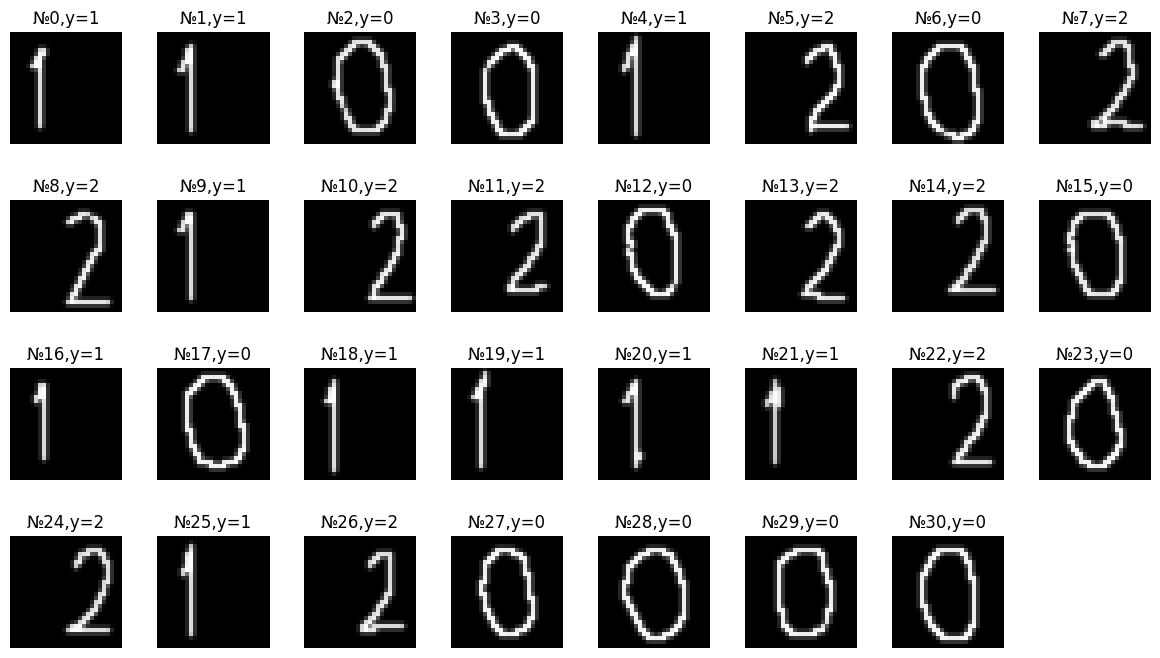

In [99]:
print("Обучающая часть.")
print(y_train)

print(f"Изображений в наборе {y_train.shape[0]}:")
for class_label, count in zip (*np.unique(y_train, return_counts=True)):
    print(f'  Класс_{class_label}, кол-во {count:>3} шт.' )

# Вывод изображений набора в графическом виде
plotSetOfImages(X_train, y_train)

Проверочная часть.
[2 2 1 2 1 2 0 2 1 0 0 1 1 0]
Изображений в наборе 14:
  Класс_0, кол-во   4 шт.
  Класс_1, кол-во   5 шт.
  Класс_2, кол-во   5 шт.


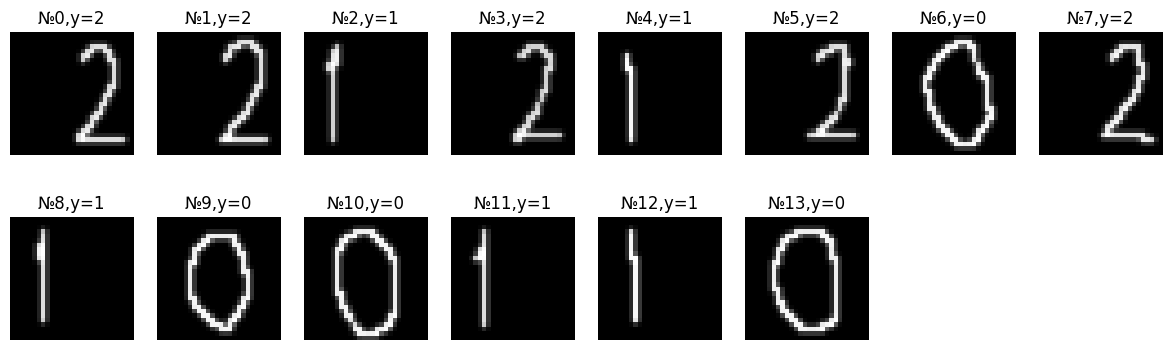

In [100]:
print("Проверочная часть.")
print(y_test)

print(f"Изображений в наборе {y_test.shape[0]}:")
for class_label, count in zip (*np.unique(y_test, return_counts=True)):
    print(f'  Класс_{class_label}, кол-во {count:>3} шт.' )

# Вывод изображений набора в графическом виде
plotSetOfImages(X_test, y_test)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

### Кодирование меток классов "one-hot encoded"

In [101]:
y_train

array([1, 1, 0, 0, 1, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 1, 1,
       2, 0, 2, 1, 2, 0, 0, 0, 0])

In [102]:
y_test

array([2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 0, 1, 1, 0])

In [103]:
y_train =  tf.keras.utils.to_categorical(y_train)
y_test  =  tf.keras.utils.to_categorical(y_test)

print("y_train", y_train.shape)
print(y_train)
print()
print("y_test", y_test.shape)
print(y_test)

y_train (31, 3)
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]

y_test (14, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Работа с нейронной сетью

### Создание НС. Создание структуры и выбор начальных параметров

In [104]:
print("X_train", X_train.shape)

X_train (31, 28, 28)


In [105]:
print("y_train", y_train.shape)
y_train

y_train (31, 3)


array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [106]:
with tf.device('/CPU:0'):
    ###########################################
    #▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
    # 2.1) Построение модели нейронной сети многослойного(Sequential) типа ----------------------------
    model = tf.keras.Sequential()

    # ДОБАВЛЕНИЕ НОВЫХ СЛОЁВ --------------------------
    # Входной слой, обеспечивает приём всхе пикселей иходного изображения
    model.add(  layers.Input(
                    shape=(28,28)
    ))

    # Слой для преобразование изображения в одномерный вектор
    model.add(  layers.Flatten()  )

 # Скрытый полносвязный слой
    model.add(  layers.Dense(
                    units= 32,          # параметр "units" - кол-во узлов/нейронов на данном слое
                    activation= None    # параметр "activation" - вид функции активации
    ))
    
    # Скрытый полносвязный слой
    model.add(  layers.Dense(
                    units= 16,          # параметр "units" - кол-во узлов/нейронов на данном слое
                    activation= None    # параметр "activation" - вид функции активации
    ))

    # Cлой нелинейной функцией активации
    model.add(  layers.Activation(
                    activation="sigmoid"
    ))

    # Скрытый полносвязный слой
    model.add(  layers.Dense(
                    units= 8,           # параметр "units" - кол-во узлов/нейронов на данном слое
                    activation= None    # параметр "activation" - вид функции активации
    ))

    # Cлой нелинейной функцией активации
    model.add(  layers.Activation(
                    activation=tf.keras.activations.sigmoid # параметр "activation" - вид функции активации
    ))

    # Последний слой определяющий кол-во принадлежностей к классам
    model.add(  layers.Dense(
                    units= 3,           # параметр "units" - кол-во узлов/нейронов на данном слое
                    activation= None    # параметр "activation" - вид функции активации
    ))

    # Слой нелинейной функцией активации для обработки ответов нейронной сети
    # Softmax преобразует ответы всех выходных НС в вероятности принадлежности к классам, сумма всех вероятностей = 1.0
    model.add(  layers.Activation(
                    activation=activations.softmax # параметр "activation" - вид функции активации
    ))

In [107]:
with tf.device('/CPU:0'):
    # 2.2) Функции потерь и функции оптимизации --------------------------------------------------------------------
    fLoss      = losses.CategoricalCrossentropy()
    #fLoss      = losses.BinaryCrossentropy()
    #floss      = losses.SparseCategoricalCrossentropy()

    fOptimizer = optimizers.Adam(learning_rate=0.01)
    #fOptimizer = optimizers.SGD(learning_rate=0.01)
    #fOptimizer = optimizers.RMSprop(learning_rate=0.01)

    fMetric  = [
                  metrics.CategoricalAccuracy(),
                  metrics.CategoricalCrossentropy(),
                  metrics.Precision(),
    ]

In [108]:
with tf.device('/CPU:0'):
    totalHistoryLossTrain=list() # Вспомогательный список для хранение полной истории обучения
    totalHistoryLossTest =list() # Вспомогательный список для хранение полной истории обучения
    globalEpochCounter = 1

    model.compile(
        loss      = fLoss,
        optimizer = fOptimizer,
        metrics   = [ fMetric ]
    )
    #▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲
    ###########################################

    print("Вывод короткой информации о структуре НС")
    model.summary()

Вывод короткой информации о структуре НС
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                25120     
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 activation_8 (Activation)   (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 activation_9 (Activation)   (None, 8)                 0         
                                                                 
 dense_15 (De

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

### Обучение НС

In [109]:
model.layers[0].input_shape

(None, 28, 28)

In [110]:
X_train.shape[0]

31

Обучение на образце №0  y=[0. 1. 0.]
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1903 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.1903 - precision_4: 1.0000
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1916 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.1916 - precision_4: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1918 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.1918 - precision_4: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1912 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.1912 - precision_4: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.1896 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.1896 - precision_4: 1.0000
Обучение на образце №1  y=[0. 1. 0.]
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1873 - categorical_accuracy: 1.0000

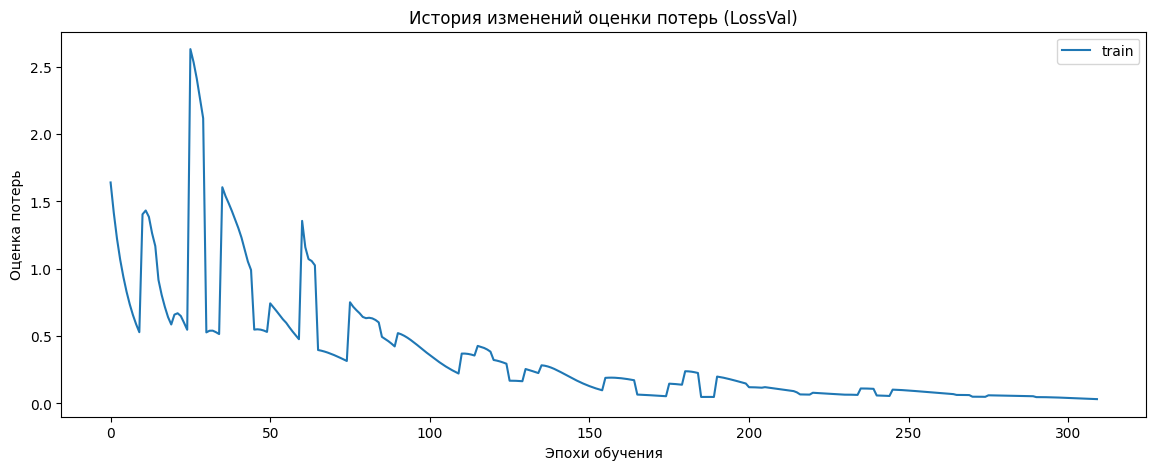

In [112]:
with tf.device('/CPU:0'):
    for index in range(0, X_train.shape[0]):
        print(f"Обучение на образце №{index}  y={y_train[index]}")

        # получение массива пикселей выбранного единственного изображения
        singleImg_X = X_train[index]; # print(singleImg_X.shape)
        singleImg_y = y_train[index]; # print(singleImg_y.shape)

        # # Вывод выбранного изображения в графическом виде
        # plt.imshow(singleImg_X, cmap='gray')
        # plt.subplots_adjust(wspace=0.2, hspace=0.2)
        # plt.axis(True)
        # plt.title(f"Номер изобр.={index}, класс={singleImg_y}")

        # переупаковка единственного изображения для подачи на вход НС
        # (28, 28) -> (1, 28, 28)
        singleImg_X = singleImg_X.reshape(1, 28, 28) ; # print(singleImg_X.shape)
        singleImg_y = singleImg_y.reshape(1,3)       ; # print(singleImg_y.shape)

        ###########################################
        #▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
        # 3) Обучение/продолжение обучения сети -------------------
        history = model.fit(
            singleImg_X,  # обучающие X,  размер (1, 28, 28)
            singleImg_y,  # обучающие Y,
            epochs=5,     # кол-во эпох обучения
            batch_size=1, # кол-во образцов в каждой эпохе
            #validation_data=[ # опционально проверочные X и Y
            #    X_test,
            #    y_test, ],
        )
        #▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲
        ###########################################

        # Сбор и дополнение полной истории обучения
        totalHistoryLossTrain.extend(history.history['loss'])
        if 'val_loss' in history.history.keys():
            totalHistoryLossTest.extend(history.history['val_loss'])

    # После обучения ----------------------------------------------
    # Отобразить график изменения оценки потерь по эпохам обучения
    plt.figure(figsize=(14,5))
    plt.plot(totalHistoryLossTrain, label='train')
    if 'val_loss' in history.history.keys():
        plt.plot(totalHistoryLossTest, label='test')
    plt.legend()
    plt.title("История изменений оценки потерь (LossVal)")
    plt.ylabel("Оценка потерь")
    plt.xlabel("Эпохи обучения")
    ###plt.ylim ( (0, 0.03) ) # область видимости для оси "Оценки потерь"

In [113]:
# Осмотреть список значений оценки потерь по эпохам
# totalHistoryLossTrain

### Опрос НС одиночными изображениями

In [114]:
X_test.shape[0]

14

Выбрано изображение № 2 из 14
Размер изображения: (28, 28)


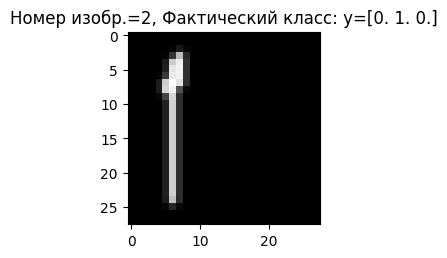

In [115]:
index =2
print(f'Выбрано изображение № {index} из {X_test.shape[0]}')

# Опрос модели
with tf.device('/CPU:0'):
    # Получение массива пикселей выбранного изображения
    singleImg_X = X_test[index]
    singleImg_y = y_test[index]
    print("Размер изображения:", singleImg_X.shape)
    #print("Размер массива y с ожидаемым ответом:", singleImg_y.shape)

    # Вывод выбранного изображения в графическом виде
    plt.figure(figsize=(2.5,2.5))
    plt.imshow(singleImg_X, cmap='gray')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.axis(True)
    plt.title(f"Номер изобр.={index}, Фактический класс: y={singleImg_y}")
    plt.show()

In [116]:
# Опрос модели
with tf.device('/CPU:0'):
    # Переупаковка единственного изображения для подачи на вход НС
    # (28, 28) -> (1, 28, 28)
    singleImg_X = singleImg_X.reshape(1, 28, 28)
    print("Размер изображения:", singleImg_X.shape)
    print("Размер массива y с ожидаемым ответом:", singleImg_y.shape)


    # Вызов ф. predict - вычисление одиночного ответа
    y_pred = model.predict(singleImg_X.reshape(1, 28, 28))
    print()
    print(f'Ожидаемый ответ: {singleImg_y}')
    print(f'Ответ НС: {y_pred}')

    print('Вероятность принадлежности к каждому классу:')
    for i, probability in enumerate(y_pred[0]):
        print(f'  Класс_{i}: вероятность {probability:>7.1%}' )

Размер изображения: (1, 28, 28)
Размер массива y с ожидаемым ответом: (3,)
1/1 [==============================] - 0s 50ms/step

Ожидаемый ответ: [0. 1. 0.]
Ответ НС: [[0.02889525 0.94667774 0.02442696]]
Вероятность принадлежности к каждому классу:
  Класс_0: вероятность    2.9%
  Класс_1: вероятность   94.7%
  Класс_2: вероятность    2.4%


### Оценка общей точности

In [117]:
X_test.shape

(14, 28, 28)

In [118]:
# Опрос модели
with tf.device('/CPU:0'):
    print('Вычисление ответов - вызов model.predict(X)')
    y_pred_all = model.predict(X_test)

    print(f'\nОтветы модели (вероятности принадлежности) на все предъявленные образцы:')
    #print(y_pred_all) # Вывод сырых значений
    print(pd.DataFrame(y_pred_all).applymap(lambda x: '{:>7.2%}'.format(x)).values) # Форматированный вывод

Вычисление ответов - вызов model.predict(X)
1/1 [==============================] - 0s 18ms/step

Ответы модели (вероятности принадлежности) на все предъявленные образцы:
[['  3.28%' '  1.81%' ' 94.91%']
 ['  3.28%' '  1.81%' ' 94.91%']
 ['  2.89%' ' 94.67%' '  2.44%']
 ['  3.28%' '  1.81%' ' 94.91%']
 ['  2.90%' ' 94.66%' '  2.44%']
 ['  3.28%' '  1.81%' ' 94.91%']
 [' 96.90%' '  1.20%' '  1.90%']
 ['  3.26%' '  1.83%' ' 94.91%']
 ['  2.89%' ' 94.67%' '  2.44%']
 [' 96.90%' '  1.20%' '  1.90%']
 [' 96.90%' '  1.20%' '  1.90%']
 ['  2.89%' ' 94.67%' '  2.44%']
 ['  2.90%' ' 94.66%' '  2.44%']
 [' 96.90%' '  1.20%' '  1.90%']]


C:\Users\User\AppData\Local\Temp\ipykernel_19040\2575325105.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.DataFrame(y_pred_all).applymap(lambda x: '{:>7.2%}'.format(x)).values) # Форматированный вывод


In [119]:
print(f'\nВычисленный y_pred_all:\nПолучить из вероятностей заключения (номер класса с максимальной вероятностью)')
y_pred_all_labels = tf.argmax(y_pred_all, axis=1)
print(y_pred_all_labels)


Вычисленный y_pred_all:
Получить из вероятностей заключения (номер класса с максимальной вероятностью)
tf.Tensor([2 2 1 2 1 2 0 2 1 0 0 1 1 0], shape=(14,), dtype=int64)


Схожим образом получим массив `y_test_all_labels` с информацией об ожидаемых (проверочных) ответах.

In [120]:
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [121]:
print(f'\nОжидаемый y_train:\nПолучить из вероятностей заключения (номер класса с максимальной вероятностью)')
y_test_all_labels = tf.argmax(y_test, axis=1)
print(y_test_all_labels)


Ожидаемый y_train:
Получить из вероятностей заключения (номер класса с максимальной вероятностью)
tf.Tensor([2 2 1 2 1 2 0 2 1 0 0 1 1 0], shape=(14,), dtype=int64)


tf.Tensor(
[[4 0 0]
 [0 5 0]
 [0 0 5]], shape=(3, 3), dtype=int32)


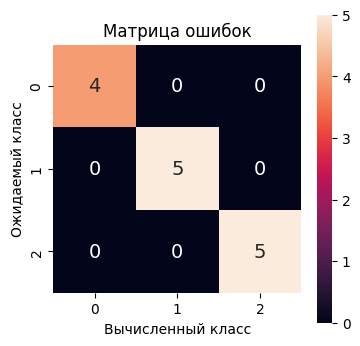

Вывести информацию о соответствии классов проверочных образцов
  Изобр. № 0, Фактический Класс_2, Вычисленный Класс_2 вероятность 94.91% 
  Изобр. № 1, Фактический Класс_2, Вычисленный Класс_2 вероятность 94.91% 
  Изобр. № 2, Фактический Класс_1, Вычисленный Класс_1 вероятность 94.67% 
  Изобр. № 3, Фактический Класс_2, Вычисленный Класс_2 вероятность 94.91% 
  Изобр. № 4, Фактический Класс_1, Вычисленный Класс_1 вероятность 94.66% 
  Изобр. № 5, Фактический Класс_2, Вычисленный Класс_2 вероятность 94.91% 
  Изобр. № 6, Фактический Класс_0, Вычисленный Класс_0 вероятность 96.90% 
  Изобр. № 7, Фактический Класс_2, Вычисленный Класс_2 вероятность 94.91% 
  Изобр. № 8, Фактический Класс_1, Вычисленный Класс_1 вероятность 94.67% 
  Изобр. № 9, Фактический Класс_0, Вычисленный Класс_0 вероятность 96.90% 
  Изобр. № 10, Фактический Класс_0, Вычисленный Класс_0 вероятность 96.90% 
  Изобр. № 11, Фактический Класс_1, Вычисленный Класс_1 вероятность 94.67% 
  Изобр. № 12, Фактический Класс_1,

In [122]:
# Создать матрицу ошибок как массив
cm = tf.math.confusion_matrix(
    labels      =y_test_all_labels, # ожидаемые/проверочные метки классов
    predictions =y_pred_all_labels,  # вычисленные метки классов
)
print(cm)

# Отобразить матрицу ошибок в графическом виде
plt.figure(figsize=[4,4])
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14}, square = True)
plt.xlabel('Вычисленный класс')
plt.ylabel('Ожидаемый класс')
plt.title('Матрица ошибок')
plt.show()

print ('Вывести информацию о соответствии классов проверочных образцов')
for i, (y_test_val, y_pred_val ) in enumerate (
                                      zip (  y_test_all_labels.numpy(),
                                             y_pred_all_labels.numpy())
                                    ):
  print(f'  Изобр. № {i}, Фактический Класс_{y_test_val}, Вычисленный Класс_{y_pred_val} вероятность {y_pred_all[i][y_pred_val]:.2%} ',end='')
  if y_test_val!=y_pred_val:
    print('!!!Ошибка!!!',end='')
  print()


### Опрос модели прямым вводом изображений

In [125]:
#Создать экземпляр окна и отобразить
# передать в качестве параметра обученную модель НС
myWinTK ( modelForPredict=model)

Найдена диретория D:\NS\imgs
Режим распознования нарисованного изображения
1/1 [==============================] - 0s 16ms/step
